<a href="https://colab.research.google.com/github/Archith91/handson-ml/blob/master/CIS_520_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CIS 520 Project

#1 Libraries and setup

###1.1 Importing packages

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

###1.2 Loading and parsing data

In [ ]:
path = '/content/drive/MyDrive/CIS 520/CIS 520 Final Project/Datasets/train.json'
data_df = pd.read_json(path)

In [ ]:
uuid = []
category = []
title = []
title_len = []
description = []
description_len = []
listed_price = []
image_file = []
image_indicator = []
num_messages = []
outcome = []
final_price = []
for i in range(len(data_df)):
  uuid.append(str(data_df['uuid'][i]))
  category.append(str(data_df['scenario'][i]['category']))
  kbs_len = len(data_df['scenario'][i]['kbs'])
  title.append(str(data_df['scenario'][i]['kbs'][kbs_len - 1]['item']['Title']))
  title_len.append(len(data_df['scenario'][i]['kbs'][kbs_len - 1]['item']['Title']))
  description.append('. '.join(map(str, data_df['scenario'][i]['kbs'][kbs_len - 1]['item']['Description'])))
  description_len.append(len('. '.join(map(str, data_df['scenario'][i]['kbs'][kbs_len - 1]['item']['Description']))))
  listed_price.append(data_df['scenario'][i]['kbs'][kbs_len - 1]['item']['Price'])
  image_file.append(str(data_df['scenario'][i]['kbs'][kbs_len - 1]['item']['Images'])[1:-1])
  if (data_df['scenario'][i]['kbs'][kbs_len - 1]['item']['Images'] == []):
    image_indicator.append(0)
  else:
    image_indicator.append(1)
  num_messages.append(len(data_df['events'][i])-2)
  outcome.append(data_df['outcome'][i]['reward'])
  if (data_df['outcome'][i]['reward']==1):
    final_price.append(data_df['outcome'][i]['offer']['price'])
  else:
    final_price.append('na')

In [ ]:
zippedList =  list(zip(uuid, category, title, title_len, description, description_len, listed_price, image_file, image_indicator, num_messages, outcome, final_price))
index = range(len(data_df))
cleaned_data_df = pd.DataFrame(zippedList, columns = ['UUID', 'Category', 'Title', 'Title_len', 'Description', 'Description_len', 'Listed_price', 'Image_file', 'Image_indicator', 'Num_messages', 'Outcome', 'Final_price'], index=index)
cleaned_data_df.set_index('UUID',inplace=True)
cleaned_data_df[0:5]

,Category,Title,Title_len,Description,Description_len,Listed_price,Image_file,Image_indicator,Num_messages,Outcome,Final_price
UUID,,,,,,,,,,,
C_fe3d143826f44a8db1072188f5345e8a,phone,Verizon Car Charger with Dual Output Micro USB...,60,Charge two devices simultaneously on the go. T...,520,10,'phone/6149527852_0.jpg',1,7,1,7
C_4566b2e6938a4a6a8e714e799d780e71,bike,Long board custom bilt from the board up,40,Hey there cl I have a long board for sale pret...,316,200,'bike/6151236842_0.jpg',1,11,1,145
C_f82ff19f74094889873c8acc58ee582f,housing,A 4 bedroom single family house for rent in ce...,59,This is a single family house in an excellent ...,706,3200,,0,8,1,1900
C_15d928e7d3db4380a9d6a9a5e83fcd09,furniture,Sectional Couch,15,I am remodeling my space and selling a beautif...,357,585,'furniture/6131245434_0.jpg',1,4,0,na
C_c4e882c43dd746ad994226df5cc24eb7,furniture,Beautiful Cherry Hutch,22,MUST SEE!!!. Like new ! - making space in our ...,252,1000,'furniture/6144504669_0.jpg',1,2,0,na


#2 EDA and Feature engineering

###2.1 One-hot encoding categories

In [ ]:
cleaned_data_df.Category = cleaned_data_df.Category.astype('category')
categories_onehot = pd.get_dummies(cleaned_data_df['Category'])
categories_onehot

,bike,car,electronics,furniture,housing,phone
UUID,,,,,,
C_fe3d143826f44a8db1072188f5345e8a,0,0,0,0,0,1
C_4566b2e6938a4a6a8e714e799d780e71,1,0,0,0,0,0
C_f82ff19f74094889873c8acc58ee582f,0,0,0,0,1,0
C_15d928e7d3db4380a9d6a9a5e83fcd09,0,0,0,1,0,0
C_c4e882c43dd746ad994226df5cc24eb7,0,0,0,1,0,0
...,...,...,...,...,...,...
C_74c4b8d02b43482886c3455666f7a337,0,1,0,0,0,0
C_9787bae8d4df4ad8b0fe38efb127b514,0,0,0,1,0,0
C_e16cf81527b6460f90fabbdffdf16d34,1,0,0,0,0,0


In [ ]:
fe_cleaned_data_df = pd.concat([cleaned_data_df, categories_onehot], axis=1, join='inner')
fe_cleaned_data_df

,Category,Title,Title_len,Description,Description_len,Listed_price,Image_file,Image_indicator,Num_messages,Outcome,Final_price,bike,car,electronics,furniture,housing,phone
UUID,,,,,,,,,,,,,,,,,
C_fe3d143826f44a8db1072188f5345e8a,phone,Verizon Car Charger with Dual Output Micro USB...,60,Charge two devices simultaneously on the go. T...,520,10,'phone/6149527852_0.jpg',1,7,1,7,0,0,0,0,0,1
C_4566b2e6938a4a6a8e714e799d780e71,bike,Long board custom bilt from the board up,40,Hey there cl I have a long board for sale pret...,316,200,'bike/6151236842_0.jpg',1,11,1,145,1,0,0,0,0,0
C_f82ff19f74094889873c8acc58ee582f,housing,A 4 bedroom single family house for rent in ce...,59,This is a single family house in an excellent ...,706,3200,,0,8,1,1900,0,0,0,0,1,0
C_15d928e7d3db4380a9d6a9a5e83fcd09,furniture,Sectional Couch,15,I am remodeling my space and selling a beautif...,357,585,'furniture/6131245434_0.jpg',1,4,0,na,0,0,0,1,0,0
C_c4e882c43dd746ad994226df5cc24eb7,furniture,Beautiful Cherry Hutch,22,MUST SEE!!!. Like new ! - making space in our ...,252,1000,'furniture/6144504669_0.jpg',1,2,0,na,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C_74c4b8d02b43482886c3455666f7a337,car,***VERY CLEAN 2011 FORD FUSION HYBRID - 76K MI...,70,"Nice clean Hybrid sedan, well maintained and ...",322,7995,'car/6133252812_0.jpg',1,10,1,6000,0,1,0,0,0,0
C_9787bae8d4df4ad8b0fe38efb127b514,furniture,Herman Miller Aeron Chair Size C,32,herman miller aeron chair. good shape. in stor...,169,350,'furniture/6125199031_0.jpg',1,7,1,250,0,0,0,1,0,0
C_e16cf81527b6460f90fabbdffdf16d34,bike,Bike for sale!,14,Hey there! I am leaving the bay area in a mont...,180,150,,0,9,1,130,1,0,0,0,0,0


###2.2 Feature selection

####2.2.1 All non-text features

In [ ]:
X = fe_cleaned_data_df[['bike','car','electronics','furniture','housing','phone','Title_len', 'Description_len', 'Image_indicator','Listed_price', 'Num_messages']]
y = fe_cleaned_data_df['Outcome']

####2.2.2 Only num_messages

In [ ]:
X_num_m = fe_cleaned_data_df[['Num_messages']]

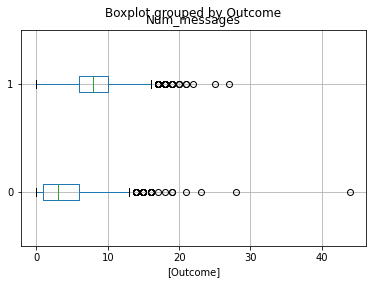

In [ ]:
fe_cleaned_data_df.boxplot(column=['Num_messages'], by=['Outcome'],vert=False)

###2.3 Train-test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=2)
x_train_nm, x_test_nm, y_train, y_test = train_test_split(X_num_m, y, test_size=0.10, random_state=2)
x_train_nm = x_train_nm.values.reshape(-1, 1)
x_test_nm = x_test_nm.values.reshape(-1, 1)

###2.4 Saving data-set to CSV

In [ ]:
# X.to_csv('X.csv')
# !cp X.csv "drive/My Drive/"
# y.to_csv('y.csv')
# !cp y.csv "drive/My Drive/"

#3 Machine learning

###3.1 Establishing baseline accuracy

In [ ]:
baseline = y_test.mean()
print(baseline)

0.72


In [ ]:
label_1 = [1 for elem in y_test if elem == 1]
label_1 = len(label_1)
label_0 = len(y_test) - label_1
#Accuracy for an all 1 prediction
acc = label_1/(label_1+label_0)
print("Samples with Label=1: ", label_1)
print("Total samples in y_test: ", len(y_test))
print("Accuracy of an all 1 prediction: ", acc)

Samples with Label=1:  378
Total samples in y_test:  525
Accuracy of an all 1 prediction:  0.72


###3.2 Logistic regression using non-text fields

####3.2.1 Without scaling and PCA

In [ ]:
clf_lr = LogisticRegression(random_state=0, max_iter=500).fit(x_train, y_train)
predictions_lr = clf_lr.predict(x_test)
score_lr = clf_lr.score(x_test, y_test)
print(round(score_lr*100, 1))
cm_lr = metrics.confusion_matrix(y_test, predictions_lr)
print(cm_lr)

84.6
[[ 84  63]
 [ 18 360]]


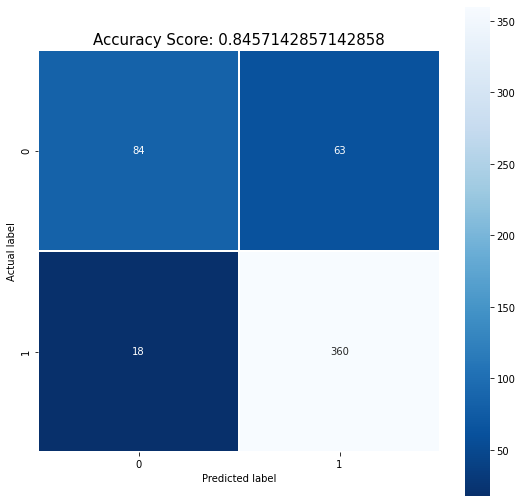

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_lr, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_lr)
plt.title(all_sample_title, size = 15);

####3.2.2 With scaling and PCA

[0.18451362 0.35142229 0.46994955 0.58396191 0.68849529 0.77891237
 0.85446065 0.9185157  0.97358883 1.         1.        ]


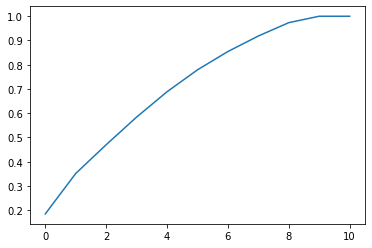

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
pca = PCA(n_components=11)
pca.fit(x_train_scaled)
print(np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
pca = PCA(n_components=9)
x_train2 = pca.fit_transform(x_train_scaled)
x_test2= pca.fit_transform(x_test_scaled)

In [ ]:
clf_lr = LogisticRegression(random_state=0).fit(x_train2, y_train)
predictions_lr = clf_lr.predict(x_test2)
score_lr = clf_lr.score(x_test2, y_test)
print(round(score_lr*100, 1))
cm_lr = metrics.confusion_matrix(y_test, predictions_lr)
print(cm_lr)

69.3
[[ 34 113]
 [ 48 330]]


####3.3.3 Using oversampling

In [ ]:
ros = RandomOverSampler(random_state=42)
x_res, y_res = ros.fit_resample(x_train2, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(x_res.shape)
print(y_res.shape)

(7076, 9)
(7076,)


In [ ]:
clf_lro = LogisticRegression(random_state=0).fit(x_res, y_res)
predictions_lro = clf_lro.predict(x_test2)
score_lro = clf_lro.score(x_test2, y_test)
print(round(score_lro*100, 1))
cm_lro = metrics.confusion_matrix(y_test, predictions_lr)
print(cm_lro)

63.0
[[ 34 113]
 [ 48 330]]


##3.3 Random forest

####3.3.1 All non-text features

In [ ]:
clf_rf = RandomForestClassifier(max_depth=4, n_estimators=50, random_state=0).fit(x_train, y_train)
predictions_rf = clf_rf.predict(x_test)
score_rf = clf_rf.score(x_test, y_test)
print(round(score_rf*100, 1))
cm_rf = metrics.confusion_matrix(y_test, predictions_rf)
print(cm_rf)

85.7
[[ 90  57]
 [ 18 360]]


####3.3.2 Only num_messages

In [ ]:
clf_rf = RandomForestClassifier(max_depth=4, n_estimators=50, random_state=0).fit(x_train_nm, y_train)
predictions_rf = clf_rf.predict(x_test_nm)
score_rf = clf_rf.score(x_test_nm, y_test)
print(round(score_rf*100, 1))
cm_rf = metrics.confusion_matrix(y_test, predictions_rf)
print(cm_rf)

86.1
[[ 92  55]
 [ 18 360]]


##3.4 Gradient-tree boosting

####3.4.1 All non-text features



In [ ]:
clf_gtb = GradientBoostingClassifier(random_state=0).fit(x_train, y_train)
predictions_gtb = clf_gtb.predict(x_test)
score_gtb = clf_gtb.score(x_test, y_test)
print(round(score_gtb*100, 1))
cm_gtb = metrics.confusion_matrix(y_test, predictions_rf)
print(cm_gtb)

86.3
[[ 92  55]
 [ 18 360]]


####3.4.2 Only num_messages

In [ ]:
clf_gtb = GradientBoostingClassifier(random_state=0).fit(x_train_nm, y_train)
predictions_gtb = clf_gtb.predict(x_test_nm)
score_gtb = clf_gtb.score(x_test_nm, y_test)
print(round(score_gtb*100, 1))
cm_gtb = metrics.confusion_matrix(y_test, predictions_rf)
print(cm_gtb)

86.1
[[ 92  55]
 [ 18 360]]
